# Predict Hotel Availability

In [1]:
# To install packages that are not installed by default, uncomment the last two lines 
# of this cell and replace <package list> with a list of necessary packages.
# This will ensure the notebook has all the dependencies and works everywhere.

import sys
!{sys.executable} -m pip install <seaborn>

/bin/bash: -c: line 0: syntax error near unexpected token `newline'
/bin/bash: -c: line 0: `/opt/conda/bin/python -m pip install <seaborn>'


In [2]:
#Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import warnings
import time
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 101)

## Data Description

Column | Description
:---|:---
`id` | The unique ID assigned to every hotel.
`region` | The region in which the hotel is located..
`latitude` | The latitude of the hotel.
`longitude` | The longitude of the hotel.
`accommodation_type` | The type of accommodation offered by the hotel. For example: Private room, Entire house/apt, etc.
`cost` | The cost of booking the hotel for one night. (in \$\$)
`minimum_nights` | The minimum number of nights stay required.
`number_of_reviews` | The number of reviews accumulated by the hotel.
`reviews_per_month` | The average number of reviews received by the hotel per month.
`owner_id` | The unique ID assigned to every owner. An owner can own multiple hotels.
`owned_hotels` | The number of hotels owned by the owner.
`yearly_availability` | It indicates if the hotel accepts bookings around the year. Values are 0 (not available for 365 days in a year) and 1 (available for 365 days in a year).

## Data Wrangling & Visualization

In [3]:
# Dataset is already loaded below
data = pd.read_csv("train.csv")

In [4]:
data.head()

,id,region,latitude,longitude,accommodation_type,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels,yearly_availability
0,13232,Manhattan,40.71854,-74.00439,Entire home/apt,170,5,7,0.56,929983,1,0
1,246,Brooklyn,40.64446,-73.95030,Entire home/apt,65,3,238,2.30,281764,1,0
2,19091,Queens,40.78573,-73.81062,Private room,85,1,0,NaN,19923341,1,1
3,34305,Manhattan,40.73863,-73.98002,Private room,210,30,0,NaN,200380610,65,1
4,444,Manhattan,40.82426,-73.94630,Shared room,75,3,38,0.42,745069,3,1


In [5]:
#Explore columns
data.columns

Index(['id', 'region', 'latitude', 'longitude', 'accommodation_type', 'cost',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'owner_id',
       'owned_hotels', 'yearly_availability'],
      dtype='object')

In [6]:
#Description
data.describe()

,id,latitude,longitude,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels,yearly_availability
count,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2870.000000,2194.000000,2.870000e+03,2870.000000,2870.000000
mean,26760.657143,40.731224,-73.950158,195.943206,11.530314,16.315331,1.157502,7.202195e+07,8.411498,0.498606
std,14140.930062,0.054942,0.049745,406.184714,37.972339,32.481722,1.355028,8.076516e+07,27.105522,0.500085
min,0.000000,40.507080,-74.242850,10.000000,1.000000,0.000000,0.010000,2.787000e+03,1.000000,0.000000
25%,15931.750000,40.692462,-73.984003,75.000000,1.000000,1.000000,0.240000,7.388002e+06,1.000000,0.000000
50%,28946.500000,40.728250,-73.956720,120.000000,3.000000,4.000000,0.650000,3.352708e+07,1.000000,0.000000
75%,38478.500000,40.762658,-73.934202,200.000000,6.000000,16.000000,1.530000,1.207625e+08,3.000000,1.000000
max,48893.000000,40.898730,-73.721730,9999.000000,999.000000,395.000000,10.370000,2.738123e+08,327.000000,1.000000


### Check the missing values

In [7]:
data.isna().sum()

id                       0
region                   0
latitude                 0
longitude                0
accommodation_type       0
cost                     0
minimum_nights           0
number_of_reviews        0
reviews_per_month      676
owner_id                 0
owned_hotels             0
yearly_availability      0
dtype: int64

In [8]:
# Calculating the percentage of the missing values
percent_missing = data.isnull().sum() * 100 / len(data)
missing_values = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
missing_values

,column_name,percent_missing
id,id,0.000000
region,region,0.000000
latitude,latitude,0.000000
longitude,longitude,0.000000
accommodation_type,accommodation_type,0.000000
cost,cost,0.000000
minimum_nights,minimum_nights,0.000000
number_of_reviews,number_of_reviews,0.000000
reviews_per_month,reviews_per_month,23.554007
owner_id,owner_id,0.000000


In [9]:
# Impute the missing values in the column reviews_per_month by the median.
# We choose median instead of mean because mean is more sensitive to the outliers.
# We didnt drop the missing rows because in that case we are going to lose information.
data['reviews_per_month'] = data['reviews_per_month'].fillna(data['reviews_per_month'].median())

In [10]:
# check the missing values again
data.isna().sum()

id                     0
region                 0
latitude               0
longitude              0
accommodation_type     0
cost                   0
minimum_nights         0
number_of_reviews      0
reviews_per_month      0
owner_id               0
owned_hotels           0
yearly_availability    0
dtype: int64

# Data Analysis

In [11]:
data['yearly_availability'].value_counts()

0    1439
1    1431
Name: yearly_availability, dtype: int64

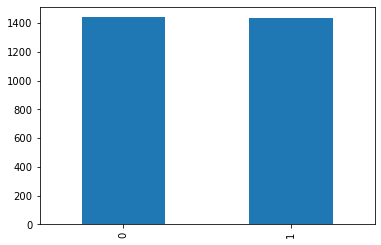

In [12]:
# plot the class distribustion
data['yearly_availability'].value_counts().plot.bar()

In [13]:
# We can see that our data set is balanced so there is not need for the over / under sampling 

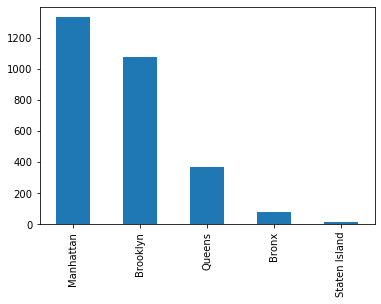

In [14]:
# plot the regions
data['region'].value_counts().plot.bar()

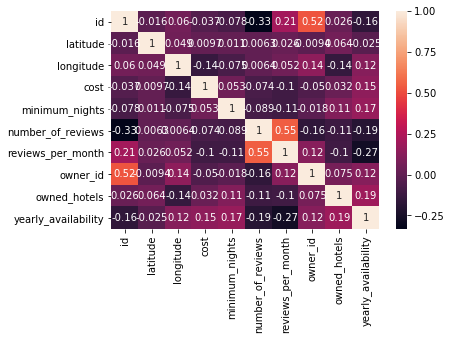

In [15]:
# Heatmap for the data correlation
sns.heatmap(data.corr(), annot=True)


### Observations:
We can see that most of the hotels belong to the Manhatten andd very few belong to Staten Island

# Data Preprocessing

In [16]:
# Drop the useless features
data= data.drop('id',axis=1)

In [17]:
# Split the data from the class labels
y = data['yearly_availability']
X = data.drop('yearly_availability',axis=1) 

In [18]:
# Using the label Encoder we are going to handle the categorical features
le1 = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()


X['region'] = le1.fit_transform(X['region'])
X['accommodation_type'] = le2.fit_transform(X['accommodation_type'])
X['owner_id'] = le3.fit_transform(X['owner_id'])
X

,region,latitude,longitude,accommodation_type,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels
0,2,40.71854,-74.00439,0,170,5,7,0.56,141,1
1,1,40.64446,-73.95030,0,65,3,238,2.30,59,1
2,3,40.78573,-73.81062,1,85,1,0,0.65,984,1
3,2,40.73863,-73.98002,1,210,30,0,0.65,2085,65
4,2,40.82426,-73.94630,2,75,3,38,0.42,119,3
...,...,...,...,...,...,...,...,...,...,...
2865,2,40.74316,-73.98038,1,400,2,0,0.65,2360,1
2866,2,40.73523,-73.99465,1,180,3,2,0.07,1735,1
2867,2,40.76619,-73.98987,0,179,3,17,0.67,768,1
2868,2,40.74637,-73.97207,1,200,30,0,0.65,326,49


In [19]:
# Standardize the data so the mean of the dataset will be zero and std will be 1.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Visualization, Modeling, Machine Learning

Build a model that categorizes hotels on the basis of their yearly availability.  Identify how different features influence the decision. Please explain the findings effectively to technical and non-technical audiences using comments and visualizations, if appropriate.
- **Build an optimized model that effectively solves the business problem.**
- **The model will be evaluated on the basis of Accuracy.**
- **Read the test.csv file and prepare features for testing.**

## Machine Learning Modelling

# Random Forest

Training ACCURACY  =  : 0.9951
Training error =  0.004878048780487809


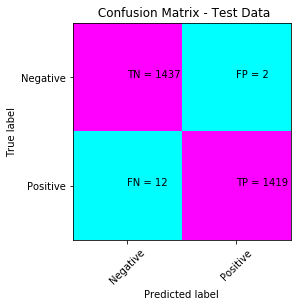

Sensivity = 0.9986101459346769
Specificity = 0.9916142557651991


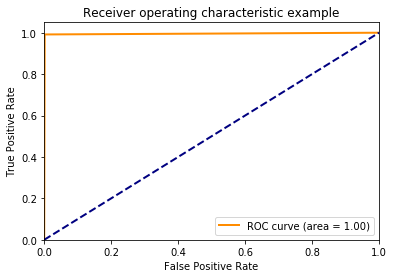

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1439
           1       1.00      0.99      1.00      1431

    accuracy                           1.00      2870
   macro avg       1.00      1.00      1.00      2870
weighted avg       1.00      1.00      1.00      2870



In [20]:
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier()
y_predi = RF_model.fit(X_scaled, y)

y_predi=RF_model.predict(X_scaled)
a=1-accuracy_score(y, y_predi)
# Check accuracy score 
print('Training ACCURACY  =  : {0:0.4f}'. format(accuracy_score(y, y_predi)))
print('Training error = ',a)


cm= confusion_matrix(y, y_predi)

#print(cm)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.cool)
classNames = ['Negative','Positive']
plt.title(' Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]
TPR=TP/(TP+FN)
TNR=TN/(TN+FP)
print('Sensivity =',TPR)
print('Specificity =',TNR)
### Compute ROC curve and ROC area for predictions on validation set
fpr, tpr, _ = roc_curve(y, y_predi)
roc_auc = auc(fpr, tpr)

### Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
print(classification_report(y, y_predi))

# Logistic Regression

Training ACCURACY =  : 0.7226
Training error =  0.27735191637630663


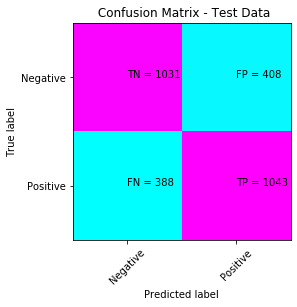

Sensivity = 0.7164697706740792
Specificity = 0.7288609364081062


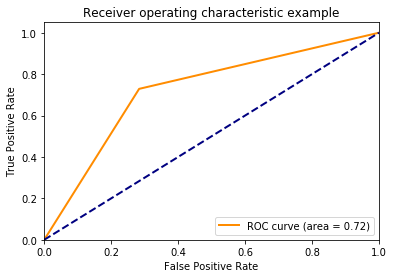

              precision    recall  f1-score   support

           0       0.73      0.72      0.72      1439
           1       0.72      0.73      0.72      1431

    accuracy                           0.72      2870
   macro avg       0.72      0.72      0.72      2870
weighted avg       0.72      0.72      0.72      2870

CPU times: user 378 ms, sys: 224 ms, total: 602 ms
Wall time: 353 ms


In [21]:
%%time
from sklearn.linear_model import LogisticRegression

LG_model = LogisticRegression()
y_predi = LG_model.fit(X_scaled, y)


y_predi=LG_model.predict(X_scaled)
a=1-accuracy_score(y, y_predi)
# Check accuracy score 
print('Training ACCURACY =  : {0:0.4f}'. format(accuracy_score(y, y_predi)))
print('Training error = ',a)




cm= confusion_matrix(y, y_predi)

#print(cm)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.cool)
classNames = ['Negative','Positive']
plt.title(' Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]
TPR=TP/(TP+FN)
TNR=TN/(TN+FP)
print('Sensivity =',TPR)
print('Specificity =',TNR)
### Compute ROC curve and ROC area for predictions on validation set
fpr, tpr, _ = roc_curve(y, y_predi)
roc_auc = auc(fpr, tpr)


### Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
print(classification_report(y, y_predi))

## SVM MODEL

Training ACCURACY =  : 0.9132
Training error =  0.0867595818815331


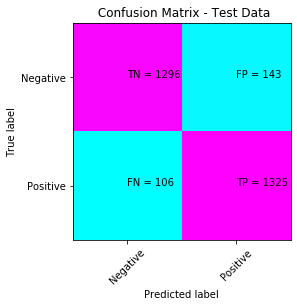

Sensivity = 0.9006254343293955
Specificity = 0.9259259259259259


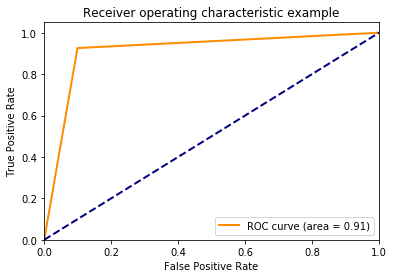

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1439
           1       0.90      0.93      0.91      1431

    accuracy                           0.91      2870
   macro avg       0.91      0.91      0.91      2870
weighted avg       0.91      0.91      0.91      2870



In [22]:
from sklearn.svm import SVC
SVM_model = SVC()
y_predi = SVM_model.fit(X_scaled, y)


y_predi=SVM_model.predict(X_scaled)
a=1-accuracy_score(y, y_predi)
# Check accuracy score 
print('Training ACCURACY =  : {0:0.4f}'. format(accuracy_score(y, y_predi)))
print('Training error = ',a)


cm= confusion_matrix(y, y_predi)

#print(cm)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.cool)
classNames = ['Negative','Positive']
plt.title(' Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]
TPR=TP/(TP+FN)
TNR=TN/(TN+FP)
print('Sensivity =',TPR)
print('Specificity =',TNR)
### Compute ROC curve and ROC area for predictions on validation set
fpr, tpr, _ = roc_curve(y, y_predi)
roc_auc = auc(fpr, tpr)


### Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
print(classification_report(y, y_predi))

 # KNN Model

Training ACCURACY =  : 0.9073
Training error =  0.09268292682926826


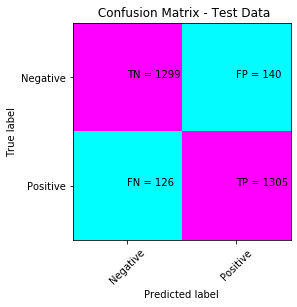

Sensivity = 0.9027102154273802
Specificity = 0.9119496855345912


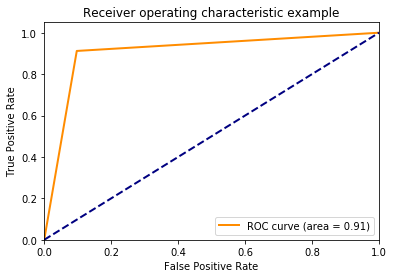

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1439
           1       0.90      0.91      0.91      1431

    accuracy                           0.91      2870
   macro avg       0.91      0.91      0.91      2870
weighted avg       0.91      0.91      0.91      2870



In [23]:
from sklearn.neighbors import KNeighborsClassifier
KNN_model = KNeighborsClassifier(n_neighbors=7)
y_predi = KNN_model.fit(X_scaled, y)


y_predi=KNN_model.predict(X_scaled)
a=1-accuracy_score(y, y_predi)
# Check accuracy score 
print('Training ACCURACY =  : {0:0.4f}'. format(accuracy_score(y, y_predi)))
print('Training error = ',a)


cm= confusion_matrix(y, y_predi)

#print(cm)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.cool)
classNames = ['Negative','Positive']
plt.title(' Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]
TPR=TP/(TP+FN)
TNR=TN/(TN+FP)
print('Sensivity =',TPR)
print('Specificity =',TNR)
### Compute ROC curve and ROC area for predictions on validation set
fpr, tpr, _ = roc_curve(y, y_predi)
roc_auc = auc(fpr, tpr)


### Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
print(classification_report(y, y_predi))

### Observations
We can see that Random forest performs well as compared to the orther ML models.<br>
We select Random forest for the predictions on test data.


# Testing the models

In [24]:
#Loading Test data
test_data=pd.read_csv('test.csv')
test_data.head()

,id,region,latitude,longitude,accommodation_type,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels
0,19215,Brooklyn,40.70912,-73.94513,Shared room,135,2,22,0.66,4360212,1
1,36301,Brooklyn,40.57646,-73.96641,Entire home/apt,69,2,8,0.90,181356989,2
2,40566,Manhattan,40.76616,-73.98228,Private room,225,30,0,NaN,13773574,12
3,33694,Manhattan,40.77668,-73.94587,Shared room,125,30,9,0.82,6788748,1
4,28873,Manhattan,40.80279,-73.94450,Entire home/apt,43,1,13,0.72,105061915,2


In [25]:
# Check the missing values in the test dataset
test_data.isna().sum()

id                      0
region                  0
latitude                0
longitude               0
accommodation_type      0
cost                    0
minimum_nights          0
number_of_reviews       0
reviews_per_month     173
owner_id                0
owned_hotels            0
dtype: int64

There are total 173 missing values. We are replacing these missing values by the median

In [26]:
# Baisc stats of test data
test_data.describe()

,id,latitude,longitude,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels
count,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,545.000000,7.180000e+02,718.000000
mean,27909.484680,40.729173,-73.952992,183.538997,12.022284,14.735376,1.200385,7.838886e+07,8.604457
std,14173.417592,0.055754,0.047447,385.569803,55.969827,26.880378,1.429961,8.461906e+07,27.787289
min,36.000000,40.499790,-74.240840,10.000000,1.000000,0.000000,0.010000,7.355000e+03,1.000000
25%,16847.500000,40.689045,-73.982415,70.000000,1.000000,1.000000,0.290000,8.198337e+06,1.000000
50%,30372.000000,40.725595,-73.957475,110.500000,3.000000,4.000000,0.670000,3.727272e+07,1.000000
75%,39853.250000,40.763933,-73.938165,189.000000,6.000000,16.000000,1.530000,1.420999e+08,3.000000
max,48887.000000,40.893230,-73.732920,7500.000000,1250.000000,241.000000,8.940000,2.735464e+08,327.000000


In [27]:
# Impute the missing values in the column reviews_per_month by the median.
test_data['reviews_per_month'] = test_data['reviews_per_month'].fillna(test_data['reviews_per_month'].median())

In [28]:
# Checking the missing values again
test_data.isna().sum()

id                    0
region                0
latitude              0
longitude             0
accommodation_type    0
cost                  0
minimum_nights        0
number_of_reviews     0
reviews_per_month     0
owner_id              0
owned_hotels          0
dtype: int64

In [29]:
X_test = test_data.drop('id',axis=1)
X_test

,region,latitude,longitude,accommodation_type,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels
0,Brooklyn,40.70912,-73.94513,Shared room,135,2,22,0.66,4360212,1
1,Brooklyn,40.57646,-73.96641,Entire home/apt,69,2,8,0.90,181356989,2
2,Manhattan,40.76616,-73.98228,Private room,225,30,0,0.67,13773574,12
3,Manhattan,40.77668,-73.94587,Shared room,125,30,9,0.82,6788748,1
4,Manhattan,40.80279,-73.94450,Entire home/apt,43,1,13,0.72,105061915,2
...,...,...,...,...,...,...,...,...,...,...
713,Bronx,40.84590,-73.91558,Entire home/apt,77,2,36,1.81,153826581,1
714,Brooklyn,40.71026,-73.94744,Entire home/apt,145,3,43,1.36,4198285,1
715,Manhattan,40.71390,-73.99120,Entire home/apt,90,2,60,4.35,151507961,1
716,Manhattan,40.74399,-73.97204,Private room,200,30,0,0.67,221200420,23


In [30]:
# apply label encoding to transform categorical features

X_test['accommodation_type'] = le1.fit_transform(X_test['accommodation_type'])
X_test['region'] = le2.fit_transform(X_test['region'])
X_test['owner_id'] = le3.fit_transform(X_test['owner_id'])
X_test

,region,latitude,longitude,accommodation_type,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels
0,1,40.70912,-73.94513,2,135,2,22,0.66,116,1
1,1,40.57646,-73.96641,0,69,2,8,0.90,540,2
2,2,40.76616,-73.98228,1,225,30,0,0.67,214,12
3,2,40.77668,-73.94587,2,125,30,9,0.82,159,1
4,2,40.80279,-73.94450,0,43,1,13,0.72,456,2
...,...,...,...,...,...,...,...,...,...,...
713,0,40.84590,-73.91558,0,77,2,36,1.81,502,1
714,1,40.71026,-73.94744,0,145,3,43,1.36,112,1
715,2,40.71390,-73.99120,0,90,2,60,4.35,497,1
716,2,40.74399,-73.97204,1,200,30,0,0.67,586,23


In [31]:
# scaling the dataset
X_test_scaled = scaler.transform(X_test)

In [32]:
# getting predictions from model on test data
y_predicted = RF_model.predict(X_test_scaled)



**Highlight the most important features of the model for management.**

> #### Task:
- **Visualize the top 20 features and their feature importance.**


In [33]:
#Reference:https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
# Finding the feature importance
start_time = time.time()
importances = RF_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF_model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
feature_names = [f"feature  {i}" for i in X.columns]

Elapsed time to compute the importances: 0.003 seconds


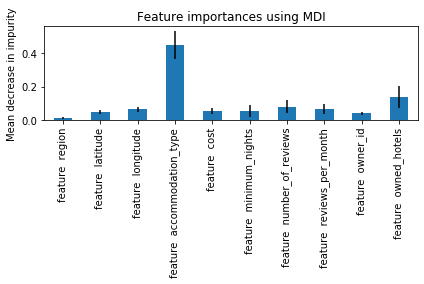

In [34]:
forest_importances = pd.Series(importances, index=feature_names)
#plt.figure(figsize=(100,100))
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

> #### Task:
- **Submit the predictions on the test dataset using your optimized model** <br/>
    For each record in the test set (`test.csv`), predict the value of the `yearly_availability` variable. Submit a CSV file with a header row and one row per test entry.

The file (`submissions.csv`) should have exactly 2 columns:
   - **id**
   - **yearly_availability**

In [35]:
# Generating the data frame for the submission
submission_df= pd.DataFrame()
submission_df['id']= test_data['id']
submission_df['yearly_availability'] = y_predicted
submission_df

,id,yearly_availability
0,19215,0
1,36301,0
2,40566,1
3,33694,0
4,28873,0
...,...,...
713,26801,0
714,20110,0
715,31383,0
716,47135,1


In [36]:
#Submission
submission_df.to_csv('submissions.csv',index=False)

---